In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import time as t
plt.style.use('seaborn-whitegrid')

credit = pd.read_csv('https://raw.githubusercontent.com/jzuver/Final-211/main/BankChurners.csv')

def laplace_mech_vec(vec, sensitivity, epsilon):
    return [v + np.random.laplace(loc=0, scale=sensitivity / epsilon) for v in vec]

def gaussian_mech_vec(vec, sensitivity, epsilon, delta):
    return [v + np.random.normal(loc=0, scale=sensitivity * np.sqrt(2*np.log(1.25/delta)) / epsilon)
            for v in vec]


def pct_error(orig, priv):
    return np.abs(orig - priv)/orig * 100.0

custom_workload = [(len(credit[credit['Customer_Age'] > 10])), 
                     (len(credit[credit['Customer_Age'] > 45])),
                    (len(credit[(credit['Customer_Age'] > 40) & (credit['Gender'] == 'M')])),
                   (len(credit[(credit['Customer_Age'] > 40) & (credit['Gender'] == 'F')])),
                   (len(credit[(credit['Customer_Age'] < 40) & (credit['Gender'] == 'F')])),
                   (len(credit[(credit['Customer_Age'] == 40) & (credit['Education_Level'] == 'Graduate')])),
                   (len(credit[credit['Marital_Status'] == 'Single']) & len(credit[credit['Gender'] == 'M'])),
                   (len(credit[credit['Marital_Status'] == 'Single']) & len(credit[credit['Gender'] == 'F'])),
                   (len(credit[credit['Dependent_count'] == 4])),
                   (len(credit[credit['Card_Category'] ==  'Blue'])),
                   (len(credit[credit['Education_Level'] ==  'Uneducated'])),
                    (len(credit[credit['Credit_Limit'] >  10000])),
                   (len(credit[credit['Months_on_book'] >  36])),
                   (len(credit[(credit['Customer_Age'] < 30) & (credit['Education_Level'] == 'High School')])),
                         (len(credit[(credit['Customer_Age'] > 30) & (credit['Card_Category'] == 'Silver')]))
                  ]
real_answers = custom_workload



## Vector-Valued Laplace Mechanism on Workload of Queries
Below we perform the vector-valued Laplace Mechanism on a workload of queries on multiple columns in the data, and the first 5 answers and average absolute error are displayed.

In [36]:
def workload_laplace_vec(workload, epsilon):
    # create parameters for range_query and list to store 
    noisy_vec_vals = laplace_mech_vec(workload, len(workload), epsilon)
    return noisy_vec_vals
print('First 5 answers:', workload_laplace_vec(custom_workload, 1.0)[:5])

First 5 answers: [10126.37589987675, 5472.5800621736, 3614.2834119687204, 4114.332771164273, 1069.3932145557974]


In [37]:
Lerrors = [abs(r_a - l_a) for (r_a, l_a) in zip(real_answers, workload_laplace_vec(custom_workload, 1.0))]
print('Average absolute error:', np.mean(Lerrors))

Average absolute error: 10.785451802699079


## Vector-Valued Gaussian Mechanism on Workload of Queries
Below we perform the vector-valued Gaussiam Mechanism on a workload of queries on multiple columns in the data, and the first 5 answers and average absolute error are displayed.

In [38]:
def workload_gaussian_vec(workload, epsilon, delta):
    noisy_vec_vals = gaussian_mech_vec(workload, np.sqrt(len(workload)), epsilon, delta)
    return noisy_vec_vals
print('First 5 answers:', workload_gaussian_vec(custom_workload, 1.0, 1e-5)[:5])

First 5 answers: [10146.788435361897, 5459.386398562533, 3578.8522338891535, 4128.665281188296, 1040.9848606691799]


In [39]:
Gerrors = [abs(r_a - l_a) for (r_a, l_a) in zip(real_answers, workload_gaussian_vec(custom_workload, 1.0, 1e-5))]
print('Average absolute error:', np.mean(Gerrors))

Average absolute error: 14.495673983519834


## Analysis on Workload with k = 15 
Below we perform the workload_laplace_vec and workload_gaussian_vec functions 10,000 times each to get a better idea of what the true average absolute error is. As we can see from the results, when performing both mechanisms on the workload of $k$ = 15 1-sensitive results, the average absolute error appears to be very similar. 

In [6]:
def laplace_analysis(iterations):
    accumulator = 0
    for i in range(iterations):
        accumulator += np.mean([abs(r_a - l_a) for (r_a, l_a) in zip(real_answers, workload_laplace_vec(custom_workload, 1.0))])
    return accumulator / iterations    

In [7]:
laplace_analysis(10000)

15.001928950791509

In [40]:
def gaussian_analysis(iterations):
    accumulator = 0
    for i in range(iterations):
        accumulator += np.mean([abs(r_a - l_a) for (r_a, l_a) in zip(real_answers, workload_gaussian_vec(custom_workload, 1.0, 1e-5))])
    return accumulator / iterations 

In [41]:
gaussian_analysis(10000)

15.004969507800947

## Analysis on Workload with k = 15000
Below we perform the workload_gaussian_vec and workload_laplace_vec functions 1,000 times each, but this time using a much larger workload. The workload consists of $k$ = 15,000 1 sensitive results. As we can see from the analysis, the Guassian mechanism is *much* more accurate than the Laplace mechanism. This is due to the Guassian mechanism utilizing $L2$ sensitivity. Since the sensitivity is much lower, the scale of the noise being added is smaller and thus the accuracy is improved. 

In [42]:
# This function creates a workload that is the custom_workload 
# repeated 1000 times, for the purpose of testing larger workloads
def make_long_workload(iterations):
    long_workload = []
    for i in range(iterations):
        for i in custom_workload:
            long_workload.append(i)
    return long_workload

In [43]:
# create workload with k = 15,000
long_workload = make_long_workload(1000)

In [44]:
def gaussian_analysis_long(iterations):
    accumulator = 0
    for i in range(iterations):
        accumulator += np.mean([abs(r_a - l_a) for (r_a, l_a) in zip(long_workload, workload_gaussian_vec(long_workload, 1.0, 1e-5))])
    return accumulator / iterations 

In [45]:
gaussian_analysis_long(1000)

473.6180735590096

In [46]:
def laplace_analysis_long(iterations):
    accumulator = 0
    for i in range(iterations):
        accumulator += np.mean([abs(r_a - l_a) for (r_a, l_a) in zip(long_workload, workload_laplace_vec(long_workload, 1.0))])
    return accumulator / iterations    

In [47]:
laplace_analysis_long(1000)

14998.205659256677

## Efficiency 
Below we test the efficiency of both methods, for both small and large values of $k$.

In [15]:
def efficiency_small_k():
    # get time for laplace mech
    start_time_L = t.time()
    laplace_analysis(10000)
    end_time_L = t.time()
    
    # get time for Gaussian mech
    start_time_G = t.time()
    gaussian_analysis(10000)
    end_time_G = t.time()
    
    # compute total time
    total_time_L = end_time_L-start_time_L
    total_time_G = end_time_G - start_time_G
    
    return total_time_L, total_time_G

laplace_time, gaussian_time = efficiency_small_k()

print("time for laplace  analysis, k= 15:", laplace_time)
print("time for Gaussian analysis, k= 15:", gaussian_time)


time for laplace  analysis, k= 15: 0.47182393074035645
time for Gaussian analysis, k= 15: 0.8836467266082764


In [ ]:
def efficiency_large_k():
    # get time for laplace mech
    start_time_L = t.time()
    laplace_analysis_long(1000)
    end_time_L = t.time()

    # get time for Gaussian mech
    start_time_G = t.time()
    gaussian_analysis_long(1000)
    end_time_G = t.time()

    # compute total time
    total_time_L = end_time_L-start_time_L
    total_time_G = end_time_G - start_time_G

    return total_time_L, total_time_G

laplace_time, gaussian_time = efficiency_large_k()

print("time for laplace  analysis, k= 15,000:", laplace_time)
print("time for Gaussian analysis, k= 15,000:", gaussian_time)

## Average Error and Efficiency Visualized 

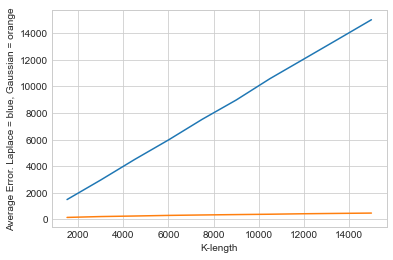

In [13]:
def compare_average_error_visualized():
    
    
    different_workloads = []
    laplace_average_error_vec = []
    gaussian_average_error_vec = []
    workload_args = []
    k_x_axis = []
    # create workloads with differents k-lengths (of queries)
    # to use in generating average error to plot
    
    # create list of arguments for make_long_workload function
    for i in range(100, 1100, 100):
        workload_args.append(i)
        
    # create workloads using those arguments   
    for i in workload_args:
        different_workloads.append(make_long_workload(i))
    
    # get laplace average error for different k-lengths
    for i in different_workloads:
        laplace_average_error_vec.append(np.mean([abs(r_a - l_a) for (r_a, l_a) in zip(i, workload_laplace_vec(i, 1.0))]))
    
    # get gaussian average errors for different k-lengths
    for i in different_workloads:
        gaussian_average_error_vec.append(np.mean([abs(r_a - l_a) for (r_a, l_a) in zip(i, workload_gaussian_vec(i, 1.0, 1e-5))]))
    

    # plot the average error for both mechanisms 
    for i in workload_args:
        k_x_axis.append(15 * i)
    
    plt.plot(k_x_axis, laplace_average_error_vec)
    plt.plot(k_x_axis, gaussian_average_error_vec)
    
    plt.xlabel("K-length")
    plt.ylabel("Average Error. Laplace = blue, Gaussian = orange")

    
compare_average_error_visualized()

In [33]:
def efficiency_visualized(efficiency_function):
    l_time, g_time = efficiency_function()
    values = [l_time, g_time]
    labels = ['Laplace', 'Gaussian']
    plt.pie(values, explode=(0, 0.1), labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=180)



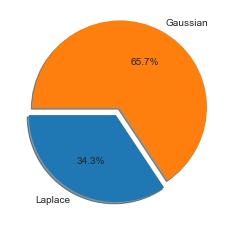

In [34]:
efficiency_visualized(efficiency_small_k)

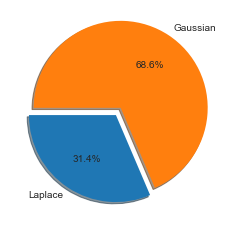

In [35]:
efficiency_visualized(efficiency_large_k)